# Homework 4

- Execute the below code, then answer the numbered questions.

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/msaricaumbc/DS_data/master/ds602/regression/car-reg-data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9055 entries, 0 to 9054
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           8164 non-null   object 
 1   transmission   8106 non-null   object 
 2   state          8152 non-null   object 
 3   condition      8173 non-null   float64
 4   odometer       8178 non-null   float64
 5   auction_value  8107 non-null   float64
 6   selling_price  9055 non-null   float64
dtypes: float64(4), object(3)
memory usage: 495.3+ KB


In [3]:
from sklearn.model_selection import train_test_split
features = [x for x in df.columns if x != 'selling_price']

X = df[features]
y = df['selling_price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

print(f'Records in training data: {X_train.shape[0]:,}')
print(f'Records in test data: {X_test.shape[0]:,}')
print('\nFeatures:')
print(*X_train.columns, sep='\n')

Records in training data: 7,244
Records in test data: 1,811

Features:
make
transmission
state
condition
odometer
auction_value


## Question 1: Split the features into two lists, one for the numerical features and another for the categorical features.

In [4]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7244 entries, 7821 to 5640
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   make           6515 non-null   object 
 1   transmission   6486 non-null   object 
 2   state          6541 non-null   object 
 3   condition      6558 non-null   float64
 4   odometer       6541 non-null   float64
 5   auction_value  6473 non-null   float64
dtypes: float64(3), object(3)
memory usage: 396.2+ KB


In [5]:
numerical_train = []
categorical_train = []
def splitting(data_frame):
    for column in X_train.columns:
        if X_train[column].dtype == 'int64' or X_train[column].dtype == 'float64':
            numerical_train.append(column)
        elif X_train[column].dtype == 'object':
            categorical_train.append(column)

    return print("The numerical features are:", numerical_train ,"\n and The categorical features are:", categorical_train)

In [6]:
splitting(X_train)

The numerical features are: ['condition', 'odometer', 'auction_value'] 
 and The categorical features are: ['make', 'transmission', 'state']


## Question 2: Using the numerical variables, create a pipeline that replaces the missing values with the median and then standardizes the values using a standard scaler.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler



num_pipeline = Pipeline([('impute_missing', SimpleImputer(strategy='median')),
                           ('standardize_num', StandardScaler())
                        ])





## Question 3: Using the categorical variables, create a pipeline that replaces the missing values with the most frequent and then use one-hot encoding to convert the data to numerical arrays.
- You should be dropping one category from each variable when using the one-hot encoder.  
- To ensure the pipeline doesn't break when it receives new/unexpected categories, you should ignore new categories.
- Use a fit transformer on the training dataset to validate all the columns are now numeric and to determine how many columns the transformed data contains.

In [8]:

cat_pipeline = Pipeline([('impute_missing_cats', SimpleImputer(strategy='most_frequent')),
                          ('create_dummies_cats', OneHotEncoder(handle_unknown='ignore', drop='first'))])

## Question 4: Combine the numerical and categorical pipelines into one data processing pipeline.
- Use a fit transformers and the training dataset to verify the data has no missing values and the correct number of columns.

In [9]:
processing_pipeline = ColumnTransformer(transformers=[('proc_numeric', num_pipeline,numerical_train ),
                                                      ('create_dummies', cat_pipeline, categorical_train)])
print(processing_pipeline)

ColumnTransformer(transformers=[('proc_numeric',
                                 Pipeline(steps=[('impute_missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardize_num',
                                                  StandardScaler())]),
                                 ['condition', 'odometer', 'auction_value']),
                                ('create_dummies',
                                 Pipeline(steps=[('impute_missing_cats',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('create_dummies_cats',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['make', 'transmission', 'state'])])


In [10]:
from scipy.sparse import csr_matrix

In [11]:
processing_pipeline.fit(X)
sparse_matrix = processing_pipeline.transform(X)[:, 2]
df = pd.DataFrame.sparse.from_spmatrix(sparse_matrix)

#Reference: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sparse.from_spmatrix.html

In [12]:
total_null_count = df.isnull().sum().sum()
print("Missing values:",total_null_count)

Missing values: 0


In [13]:
X_train_cattransformed = processing_pipeline.fit_transform(X_train)


print(f"No of columns that contains transformed data is {X_train_cattransformed.shape[1]}")

print(f"The datatype of the training dataset is {X_train_cattransformed.dtype}")

No of columns that contains transformed data is 44
The datatype of the training dataset is float64


## Question 5: Add a linear regression model to the pipeline.
- Report what the $R^2$ is using the `test` data.  

In [14]:
from sklearn.linear_model import LinearRegression

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                              ('lm', LinearRegression())
                             ])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                  

In [15]:
car_predictions = modeling_pipeline.predict(X_test)

In [16]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, car_predictions)
r2

0.8838274420792979

## Question 6: Create a plot(s) of the residuals. Do you have any concerns about patterns in the residuals that the model is neglecting to pick-up?
- Include a sentence or two on what you observe.

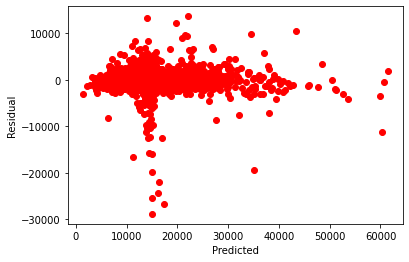

In [17]:
import matplotlib.pyplot as plt
plt.plot(car_predictions, car_predictions - y_test, 'ro')
plt.ylabel('Residual')
plt.xlabel('Predicted')
plt.show()

From the above graph we can easily tell that our model can't learn some of our records. The records are may be the outliers or else we don't have much information about that records.

## Question 7: Modify the pipeline to use a ridge regression model with an alpha value of 100. How does this change the $R^2$?

In [18]:
from sklearn.linear_model import Ridge

modeling_pipeline = Pipeline([('data_processing', processing_pipeline), 
                          ('lm', Ridge(alpha=100))
                             ])
modeling_pipeline.fit(X_train, y_train)

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('proc_numeric',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize_num',
                                                                   StandardScaler())]),
                                                  ['condition', 'odometer',
                                                   'auction_value']),
                                                 ('create_dummies',
                                                  Pipeline(steps=[('impute_missing_cats',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('create_dummies_cats',
                                  

In [19]:
car_pred = modeling_pipeline.predict(X_test)

In [20]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, car_pred)
r2

0.8824295262289474

Regularization has no impact because the model is linear, and the alpha value is too high for the optimization process to discover global minima.